# Module Two Project
## Northwind Traders: A Statistical Exploration


### Matthew Daly
Linkedin: <br>
https://www.linkedin.com/in/matthew-d-12a22156/ <br>
Please feel free to connect with me. 

Click if you would like to skip to a summary of findings.
[Summary](#1)

First, let's take a look at we will be exploring. Below is a scheme of the company's SQL database structure. 

<img src='Northwind_ERD.png'>

We will begin by attempting to answer a specific question requested by the client, then we will do a more general analysis to see if we can find any other areas of interest. 

Let's import the tools we will need...

In [1]:
import sqlite3 as sql
import numpy as np
import pandas as pd
import sqlalchemy
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from sqlalchemy.orm import Session, sessionmaker
from sqlalchemy import inspect
from sqlalchemy import MetaData
from sqlalchemy.ext.automap import automap_base
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.graphics.factorplots import interaction_plot
import warnings
warnings.filterwarnings('ignore')

and connect to the database. I will be using SQLAlchemy to query the database.

In [2]:
engine = create_engine('sqlite:///Northwind_small.sqlite', echo=True)
Session = sessionmaker(bind=engine)
session = Session()
conn = engine.connect()
connect = sql.connect('Northwind_small.sqlite')
cur = connect.cursor()

2019-04-08 21:19:45,097 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2019-04-08 21:19:45,098 INFO sqlalchemy.engine.base.Engine ()
2019-04-08 21:19:45,100 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2019-04-08 21:19:45,101 INFO sqlalchemy.engine.base.Engine ()


Now let's get the table names.

In [3]:
inspector = inspect(engine)
table_names = inspector.get_table_names()
table_names

2019-04-08 21:19:45,258 INFO sqlalchemy.engine.base.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2019-04-08 21:19:45,261 INFO sqlalchemy.engine.base.Engine ()


['Category',
 'Customer',
 'CustomerCustomerDemo',
 'CustomerDemographic',
 'Employee',
 'EmployeeTerritory',
 'Order',
 'OrderDetail',
 'Product',
 'Region',
 'Shipper',
 'Supplier',
 'Territory']

Then convert those tables into separate panda dataframes using SQL select statments and store them in a dictionary of dataframes. 

In [4]:
sql_conns = ['SELECT * FROM [Order]' if name == 'Order' else 'SELECT * FROM ' + name for name in table_names]
dataframes = {}
for table, sql_conn in zip(table_names, sql_conns):
    dataframes[table] = pd.read_sql_query(sql_conn, conn) 

2019-04-08 21:19:45,429 INFO sqlalchemy.engine.base.Engine SELECT * FROM Category
2019-04-08 21:19:45,430 INFO sqlalchemy.engine.base.Engine ()
2019-04-08 21:19:45,435 INFO sqlalchemy.engine.base.Engine SELECT * FROM Customer
2019-04-08 21:19:45,436 INFO sqlalchemy.engine.base.Engine ()
2019-04-08 21:19:45,441 INFO sqlalchemy.engine.base.Engine SELECT * FROM CustomerCustomerDemo
2019-04-08 21:19:45,441 INFO sqlalchemy.engine.base.Engine ()
2019-04-08 21:19:45,444 INFO sqlalchemy.engine.base.Engine SELECT * FROM CustomerDemographic
2019-04-08 21:19:45,445 INFO sqlalchemy.engine.base.Engine ()
2019-04-08 21:19:45,447 INFO sqlalchemy.engine.base.Engine SELECT * FROM Employee
2019-04-08 21:19:45,448 INFO sqlalchemy.engine.base.Engine ()
2019-04-08 21:19:45,453 INFO sqlalchemy.engine.base.Engine SELECT * FROM EmployeeTerritory
2019-04-08 21:19:45,454 INFO sqlalchemy.engine.base.Engine ()
2019-04-08 21:19:45,456 INFO sqlalchemy.engine.base.Engine SELECT * FROM [Order]
2019-04-08 21:19:45,457

In [5]:
dataframes.keys()

dict_keys(['Category', 'Customer', 'CustomerCustomerDemo', 'CustomerDemographic', 'Employee', 'EmployeeTerritory', 'Order', 'OrderDetail', 'Product', 'Region', 'Shipper', 'Supplier', 'Territory'])

Great now each table from the sql database is stored in its own pandas dataframe. While other sql queries may be necessary later, this will get us started. Which brings us to our client's primary question:   

## Question one: Do discounts have a statistically significant effect on the number of products customers order? If so, at what level(s) of discount?

We can frame this question as Hypotheses:

_Ho - quantity of products ordered is the same for orders with or without a discount_

_Ha - quantity of products ordered is higher in orders with a discount_

This should be fairly strait forward. We will start by looking at some descriptive statistis.

In [6]:
dataframes['OrderDetail'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 6 columns):
Id           2155 non-null object
OrderId      2155 non-null int64
ProductId    2155 non-null int64
UnitPrice    2155 non-null float64
Quantity     2155 non-null int64
Discount     2155 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 101.1+ KB


The simplest way to proceed would be to add a column to the OrderDetails dataframe to indicate if a discount was given. Then compare the mean quantity of items ordered from those orders with discounts to those orders without discounts. 

In [7]:
order_details = dataframes['OrderDetail']
order_details['Discount_status'] = order_details['Discount'].apply(lambda x: 1 if x > 0 else 0)

Now we can do a bit of visualization.

Text(0,0.5,'Average Amount of Items Ordered')

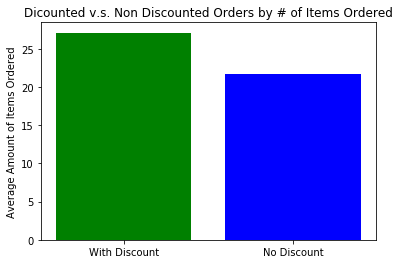

In [8]:
discount = order_details['Quantity'][order_details['Discount_status'] == 1]
no_discount = order_details['Quantity'][order_details['Discount_status'] == 0]
X = ['With Discount', 'No Discount']
y = [discount.mean(), no_discount.mean()]
plt.bar(X, y, color=('green', 'blue'))
plt.title('Dicounted v.s. Non Discounted Orders by # of Items Ordered')
plt.ylabel('Average Amount of Items Ordered')


So in looking at the mean amount of items per order, we can see a clear increase in the amount of items in orders that were offered a discount. Let's quantify this a bit by running a t-test, setting our alpha at 0.05.

In [9]:
no_discount = order_details[order_details['Discount_status']==0].copy()
discount = order_details[order_details['Discount_status']==1].copy()
p = stats.ttest_ind(no_discount['Quantity'], discount['Quantity'])[1]
p

1.1440924523215966e-10

Converted to a decimal, that would give us 0.00000000011440924523215966, well below our threshold(0.05) for rejecting the null hypothesis. We can confidently say that discounts have a statistically significant effect on the number of products customers order.

Now that we know discounts do have some effect, we will try to answer the second part of our client's question:
If so, at what level(s) of discount?

In [10]:
# let's look at the dicount levels
discount['Discount'].unique()


array([0.15, 0.05, 0.2 , 0.25, 0.1 , 0.02, 0.03, 0.04, 0.06, 0.01])

Looks like we can categorize these.

In [11]:
discount['Discount'] = discount['Discount'].apply(lambda x: 0.05 if (x > 0) & (x < 0.10) else x)
discount['Discount'].value_counts()

0.05    193
0.10    173
0.20    161
0.15    157
0.25    154
Name: Discount, dtype: int64

Now we will run an analysis of variance test to see if there is any interpaly between the various discount levels and total items ordred.

In [12]:
formula = 'Quantity ~ C(Discount)'
lm = ols(formula, discount).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                    sum_sq     df         F    PR(>F)
C(Discount)    1065.701253    4.0  0.616376  0.650947
Residual     360060.198508  833.0       NaN       NaN


With a PR of 0.65, we are well above our alpha of 0.05.  

That is not to say a more in-depth study might not reveal more nuanced relationships, say between the type of item and amount of discount, or time of order and discount level. 

## Conclusions Question One
-  There is a  statistically significant relationship between discounts on individual orders and the number of items ordered.

-  From a high level, the discount levels do not have an appreciable effect on the total quantity of items ordered.

As we enter the more free-flowing exploration of this data set, I would like to stay with discounts for a bit and see if discounts have a greater effect in the various territories...so: 

## Question two: Do discounts have a greater effect from one territory to another?

Or as Hypotheses:

_Ho - the effect of discounts is the same across territories_

_Ha - discounts have a greater effect in different territories_

To test these hypotheses I am going to merge the OrderDetail, Employee, EmployeeTerritory, and Territory tables into one data frame. I am only able to do this because of the small size of the database if it were larger I would have to use SQL query and join statements.  

In [13]:
df_order_dets = dataframes['OrderDetail'].merge(dataframes['Order'], left_on='OrderId', right_on='Id', how='left')
df_order_dets_em = df_order_dets.merge(dataframes['Employee'], left_on='EmployeeId', right_on='Id', how='left')
df_oderDets_em_ter = df_order_dets_em.merge(dataframes['EmployeeTerritory'], left_on='EmployeeId', right_on='EmployeeId', how='left')
df_od_em_ter = df_oderDets_em_ter.merge(dataframes['Territory'], left_on='TerritoryId', right_on='Id')
df_oderDets_em_ter['Discount'] = df_oderDets_em_ter['Discount'].apply(lambda x: 0.05 if (x > 0) & (x < 0.10) else x)

We will now get a list of territories and pair down the data to only that which we need to run our test. 

In [14]:
territories = np.array(df_od_em_ter.TerritoryDescription.unique())
df_with_discount =  df_od_em_ter[df_od_em_ter.Discount_status == 1]
df_with_no_discount = df_od_em_ter[df_od_em_ter.Discount_status == 0]
df_q2_data = df_with_discount[['Quantity', 'Discount', 'TerritoryDescription']]


Let's visualize the quantity of items per order by territory.

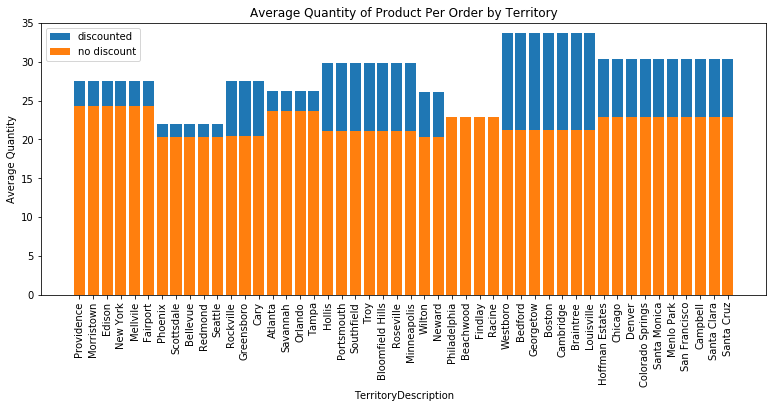

In [15]:
from matplotlib.pyplot import figure
fig = figure(num=None, figsize=(13, 5))

X = []
X2 = []
y = []
y2 = []
for terr in territories:
    X.append(terr)
    y.append(df_with_discount['Quantity'][df_with_discount['TerritoryDescription']==terr].mean())
    
for terr in territories:
    y2.append(df_with_no_discount['Quantity'][df_with_no_discount['TerritoryDescription']==terr].mean())

ax = plt.bar(X, y, label='discounted')
ax2 = plt.bar(X, y2, label='no discount')

plt.ylim(0,35)
plt.ylabel('Average Quantity')
plt.xlabel('TerritoryDescription')
plt.title('Average Quantity of Product Per Order by Territory')
plt.xticks(rotation='vertical')
plt.legend()
rects = ax.patches


We will now run an analysis of variance test to see if there is a relationship between discounts and territories, in relation to the number of items in individual orders. Again we will set our Alpha at 0.05.

In [16]:
formula = 'Quantity ~ C(TerritoryDescription)*C(Discount)'
lm = ols(formula, df_q2_data).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)


                                           sum_sq      df         F    PR(>F)
C(TerritoryDescription)             -4.816552e-01    47.0 -0.000024  1.000000
C(Discount)                          4.299201e-01     9.0  0.000113  1.000000
C(TerritoryDescription):C(Discount)  6.804796e+05   423.0  3.798226  0.051381
Residual                             1.601403e+06  3781.0       NaN       NaN


In looking at the PR(>F) value of 0.0513 for Territory/Discount we are very, very close to our Alpha of 0.05. 

## Conclusions Question Two
-  While the relationship between territory and discount does fall just outside of a statistically significant relationship, as it pertains to the number of items per order, the value is so close to our Alpha threshold that further scrutiny is definitely warranted.
<br>

-  I would suggest that as more data is accumulated this relationship is revisited, taking into account the relatively small data set we are currently working with. 
<br>

-  It is also suggested that some A/B testing is performed in those territories that appear to have the most potential to be influenced by discounts to further investigate this possible area of opportunity. 

While we are on territories I am interested in seeing if some categories of items perform better in certain regions.

## Question three: Do some categories of products sell better in different regions?

As Hypotheses:

_Ho - product categories perform the same across regions_

_Ha - product categories perform better or worse in some regions_

In [17]:
df_product_oDets = dataframes['Product'].merge(dataframes['OrderDetail'], left_on='Id', right_on='ProductId', how='left')
df_product_cat = df_product_oDets.merge(dataframes['Category'], left_on='CategoryId', right_on='Id', how='left')
df_proCat_order = df_product_cat.merge(dataframes['Order'], left_on='OrderId', right_on='Id', how='left') 
df_q3_data = df_proCat_order[['Quantity', 'CategoryName', 'ShipRegion']]

I will now run an analysis of variance test similar to the previous ones:

In [18]:
formula = 'Quantity ~ C(ShipRegion)*C(CategoryName)'
lm = ols(formula, df_q3_data).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                                      sum_sq      df          F        PR(>F)
C(ShipRegion)                   39357.276143     8.0  14.064433  6.222773e-18
C(CategoryName)                  1493.192526     7.0   0.609825  7.226761e-01
C(ShipRegion):C(CategoryName)   10506.671969    56.0   0.536370  9.979447e-01
Residual                       728971.481579  2084.0        NaN           NaN


With a PR(>F) of 9.979447e-01 we can not reject the hypothesis that product categories perform similarly across regions. 

## Conclusions Question Three
- There appears to be no statistically significant relationship between regions and product categories as pertaining to the number of items ordered.

For my final investigation, I would like to explore possible human influence over the quantity of items ordered. 

## Question Four:  Do employees have an effect on the number of items ordered?

As Hypotheses:

_Ho - there is no difference in the quantity of items ordered across employees_

_Ha - there is a difference between the quantity of items ordered between employees_

First, we need to merge some data frames.

In [19]:
df_OD_O = dataframes['OrderDetail'].merge(dataframes['Order'], left_on='OrderId', right_on='Id', how='left')
df_O_em = df_OD_O.merge(dataframes['Employee'], left_on='EmployeeId', right_on='Id', how='left')
employees = df_O_em['FirstName'].unique()

Then let us do some visualization.

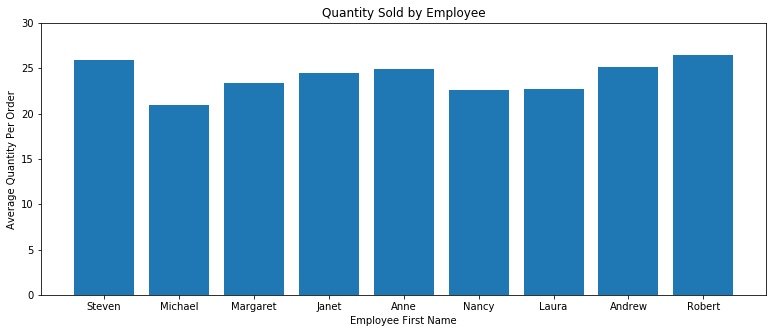

In [20]:
fig = figure(num=None, figsize=(13, 5))
X = []
y = []
for employee in employees:
    X.append(employee)
    y.append(df_O_em['Quantity'][df_O_em['FirstName']==employee].mean())
    
plt.bar(X, y)

plt.ylim(0,30)
plt.ylabel('Average Quantity Per Order')
plt.xlabel('Employee First Name')
plt.title('Quantity Sold by Employee')
rects = ax.patches

In looking at the chart there doesn't appear to be much difference between employees but let's quantify it.

In [21]:
formula = 'Quantity ~ C(FirstName)'
lm = ols(formula, df_O_em).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                     sum_sq      df         F   PR(>F)
C(FirstName)    4643.183282     8.0  1.607646  0.11745
Residual      774756.452913  2146.0       NaN      NaN


With a PR(>F) of 0.117, well above our Alpha of 0.05, there appears to be no statistically significant relationship between employees and number of items per order. 

## Conclusions Question Four
-  There appears to be no relationship between quantities ordered and the employee handling the order. 
<br>

-  This could speak to either excellent training in the sales department or a system that does not allow      individual employees to influence the outcome of orders. If it is later, ways should be explored to give salespeople opportunities to upsell customers. It is a bit surprising not to see more variance between employees. 

<a id='1'></a>

## Summation


I would like to take a moment to revisit the questions posed and the results discovered. 

### Question one:
<br>
Do discounts have a statistically significant effect on the number of products customers order? If so, at what level(s) of discount?

__results__

-  There is a clear, statistical significant relationship between discounts and number of items ordered.
<br>

-  Level of discount has no appreciable effect on the number of items ordered.



### Question two:
<br>
Do discounts have a greater effect from one territory to another?

__results__

-  While the relationship between territory and discount falls just outside of a statistically significant relationship - as it pertains to the number of items per order - the value is so close to our Alpha threshold that further scrutiny is definitely warranted.
<br>

-  I would suggest that as more data is accumulated this relationship is revisited, taking into account the relatively small data set we are currently working with. 
<br>

-  It is also suggested that some A/B testing is performed in those territories that appear to have the most potential to be influenced by discounts - to further investigate this possible area of opportunity. 

### Question three:
<br>
Do some categories of products sell better in different regions?

__results__

-  There appears to be no statistically significant relationship between regions and product categories as pertaining to the number of items ordered.  



### Question four:
<br>
Do employees have an effect on the number of items ordered?

__results__

-  There appears to be no relationship between quantities ordered and the employee handling the order. 
<br>

-  This could speak to either excellent training in the sales department or a system that does not allow      individual employees to influence the outcome of orders. If it is latter, ways should be explored to give salespeople opportunities to upsell customers. It is a bit surprising not to see more variance between employees. 

## Future Work 

- Given that there is such a clear relationship between discounts and orders, but surprisingly little difference between discounts levels on orders, much more research, including A/B testing, should be done in this area.  It could be that the discount levels are not being used to there full advantage or that employees are not empowered to leverage this obviously useful sales tool. Which leads us to:
<br/>

- It is also very surprising that we do not see more variance in employee sales performance. This could point to either an amazing training program or an inflexible sales process that does not allow employees to influence the ordering process. This may well be linked to the lack of variance we see between discount levels. Sales employees should license to use discount levels to effect sales outcomes. The sales process should be reviewed to ensure we optimize both sales employees and discount levels. Again A/B testing is recommended. 